<a href="https://colab.research.google.com/github/andydaehn/Kaggle/blob/main/California_Housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Packages

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from pathlib import Path
import matplotlib.pyplot as plt
import random
import tensorflow as tf

import lightgbm
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from lightgbm.sklearn import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

In [2]:
# reproducibility

seed_value = 142
def seeding(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    print('seeding done!')

seeding(seed_value)

seeding done!


## EDA

In [3]:
#DATAPATH = Path('../input/playground-series-s3e1')

train_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')
sample_sub = pd.read_csv('sample_submission.csv')

In [4]:
train_set.head()

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12,0.980
1,1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22,0.946
2,2,4.7750,27.0,6.535604,1.103175,1061.0,2.464602,34.71,-120.45,1.576
3,3,2.4138,16.0,3.350203,0.965432,1255.0,2.089286,32.66,-117.09,1.336
4,4,3.7500,52.0,4.284404,1.069246,1793.0,1.604790,37.80,-122.41,4.500


In [5]:
print('train_set shape: ', train_set.shape)
print('test_set shape: ', test_set.shape)

train_set shape:  (37137, 10)
test_set shape:  (24759, 9)


In [6]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37137 entries, 0 to 37136
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           37137 non-null  int64  
 1   MedInc       37137 non-null  float64
 2   HouseAge     37137 non-null  float64
 3   AveRooms     37137 non-null  float64
 4   AveBedrms    37137 non-null  float64
 5   Population   37137 non-null  float64
 6   AveOccup     37137 non-null  float64
 7   Latitude     37137 non-null  float64
 8   Longitude    37137 non-null  float64
 9   MedHouseVal  37137 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 2.8 MB


In [7]:
train_set.describe()

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,37137.00000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000
mean,18568.00000,3.851029,26.057005,5.163124,1.062204,1660.778919,2.831243,35.570030,-119.554329,2.079751
std,10720.67281,1.803167,12.158221,1.206242,0.096490,1302.469608,2.702413,2.083179,1.974028,1.158571
min,0.00000,0.499900,2.000000,0.851064,0.500000,3.000000,0.950000,32.550000,-124.350000,0.149990
25%,9284.00000,2.602300,17.000000,4.357522,1.020305,952.000000,2.394495,33.930000,-121.800000,1.208000
50%,18568.00000,3.515600,25.000000,5.068611,1.054545,1383.000000,2.744828,34.190000,-118.450000,1.808000
75%,27852.00000,4.699700,35.000000,5.858597,1.088825,1856.000000,3.125313,37.700000,-118.020000,2.660000
max,37136.00000,15.000100,52.000000,28.837607,5.873181,35682.000000,502.990610,41.950000,-114.550000,5.000010


## Missing Data

In [8]:
total = train_set.isnull().sum().sort_values(ascending=False)
percent = (train_set.isnull().sum()/train_set.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
id,0,0.0
MedInc,0,0.0
HouseAge,0,0.0
AveRooms,0,0.0
AveBedrms,0,0.0
Population,0,0.0
AveOccup,0,0.0
Latitude,0,0.0
Longitude,0,0.0
MedHouseVal,0,0.0


## Data Visualization

In [9]:
features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
target = ['MedHouseVal']

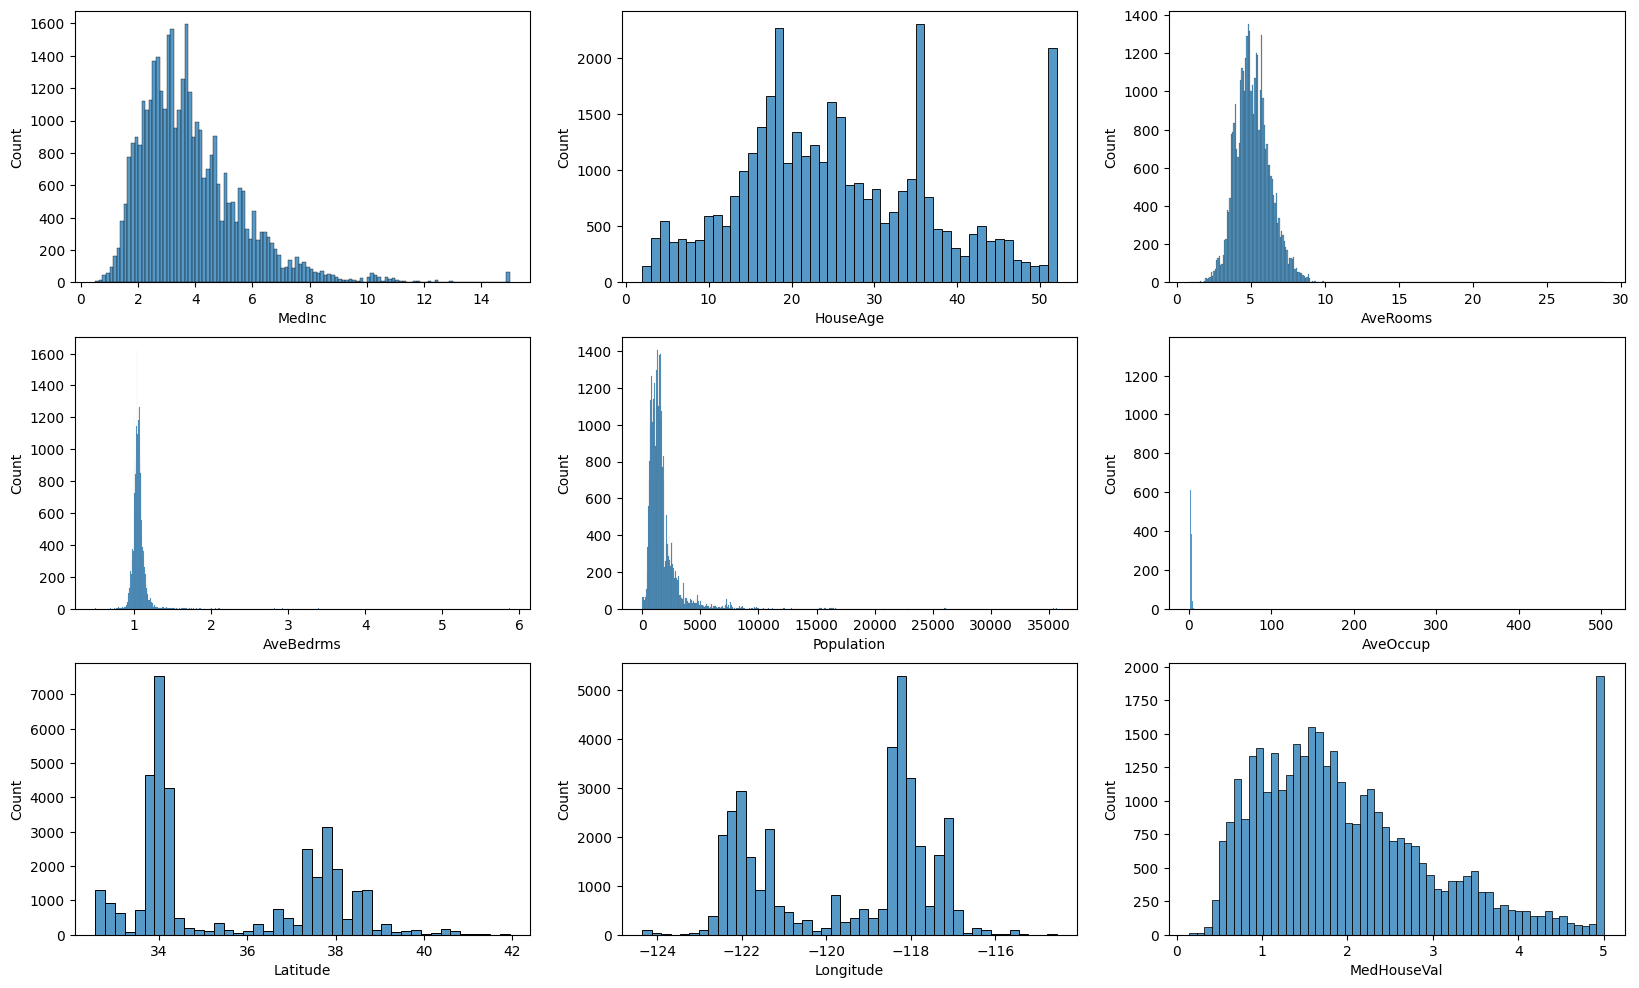

In [10]:
fig, axes = plt.subplots(3,3, figsize=(20, 12))
for i, j in zip(features+target, axes.flatten()):
    sns.histplot(train_set[i], ax=j)
plt.show()

### Relationships with Variables

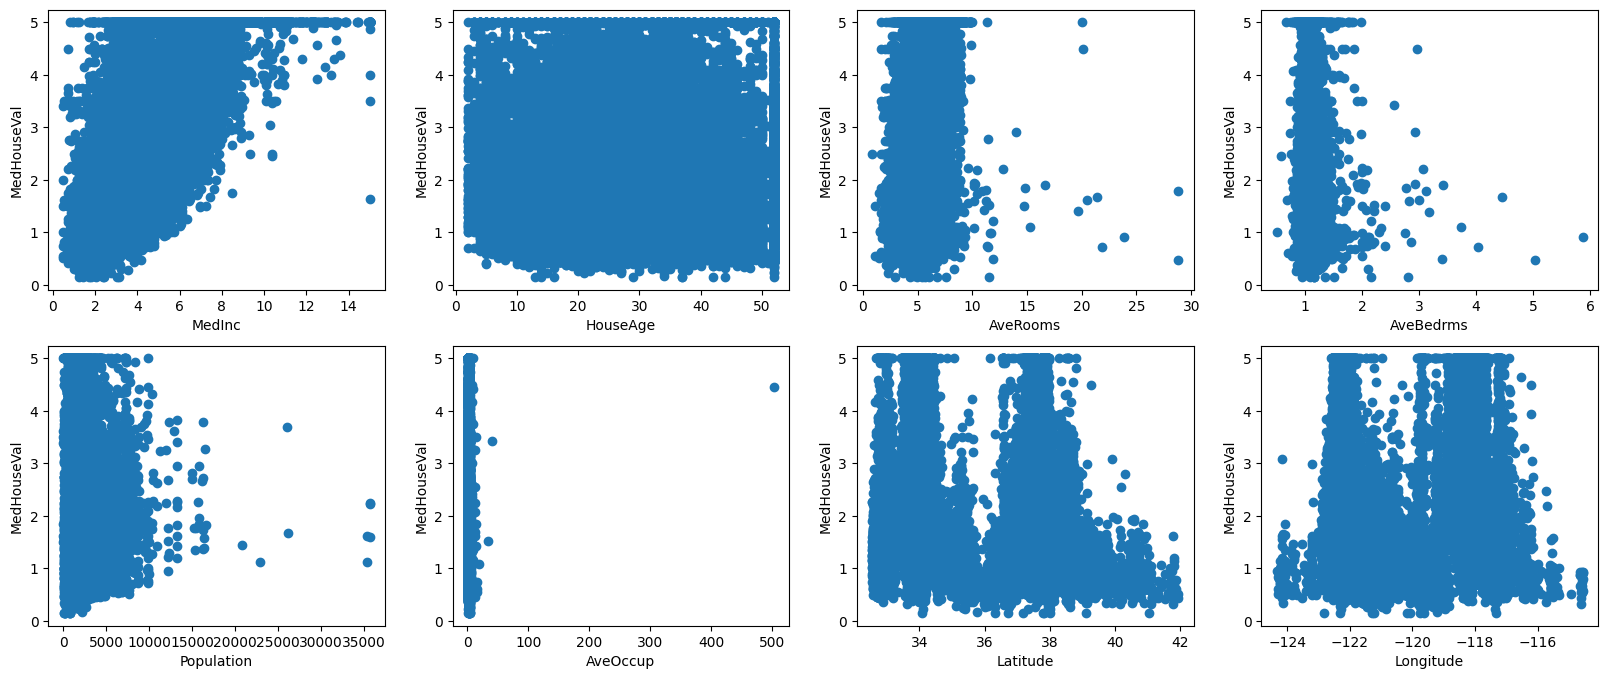

In [11]:
fig, axs = plt.subplots(2,4, figsize=(20, 8))
for i, j in enumerate(features):
    var = j
    plt.subplot(2,4,i+1)
    data = pd.concat([train_set['MedHouseVal'], train_set[var]], axis=1)
    plt.scatter(x=data[var], y=data['MedHouseVal'])
    plt.xlabel(j)
    plt.ylabel('MedHouseVal')
plt.show()

### Correlation Matrix

<Axes: >

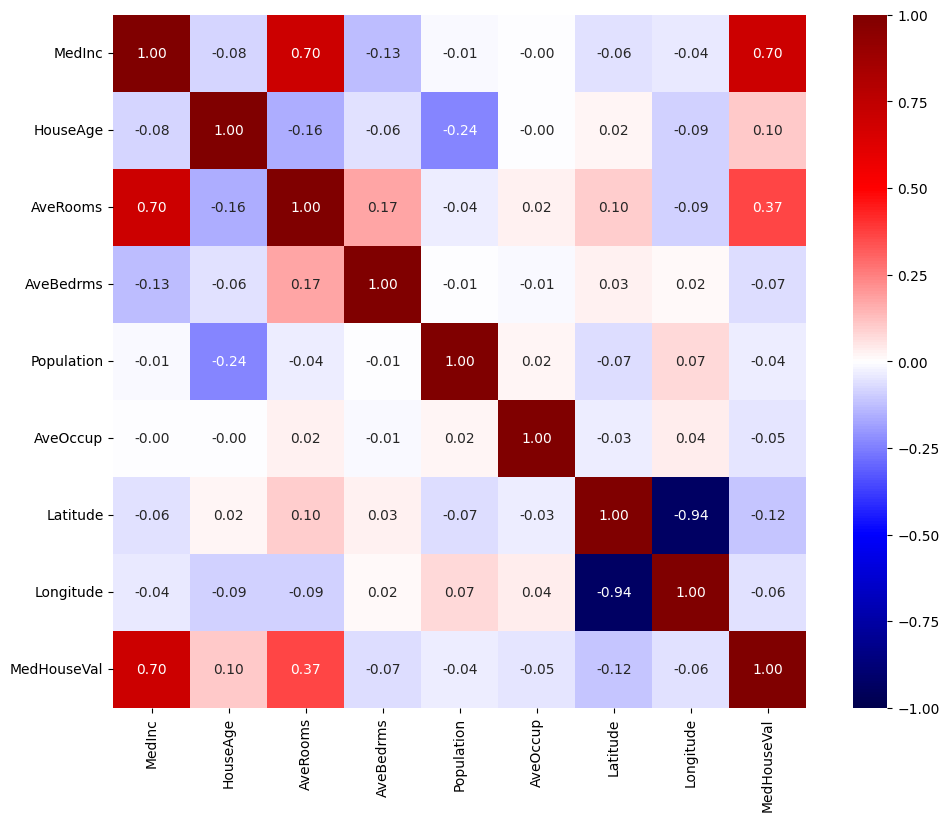

In [12]:
corrmat = train_set[features+target].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, square=True, annot=True, fmt='.2f', cmap='seismic', vmin=-1, vmax=1)

### Original Data

In [13]:
# original = fetch_california_housing()
# assert original['feature_names'] == list(features)
# assert original['target_names'][0] == target[0]

# df_original = pd.DataFrame(original['data'], columns=features)
# df_original[target[0]] = original['target']

## Train Model

In [14]:
train_set.apply(stats.zscore)

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,-1.732004,-0.812542,-0.909438,-1.107556,0.517112,-0.292355,-0.127389,-0.465655,-0.286561,-0.949244
1,-1.731911,-0.073333,-0.744939,0.704884,-0.082782,-0.120372,0.363325,1.497717,-0.843804,-0.978591
2,-1.731818,0.512422,0.077561,1.137830,0.424614,-0.460500,-0.135674,-0.412851,-0.453734,-0.434810
3,-1.731724,-0.797069,-0.827188,-1.502969,-1.002942,-0.311550,-0.274557,-1.396937,1.248393,-0.641965
4,-1.731631,-0.056030,2.133811,-0.728487,0.072984,0.101517,-0.453842,1.070480,-1.446641,2.089024
...,...,...,...,...,...,...,...,...,...,...
37132,1.731631,-0.281303,1.969311,-0.187872,0.177853,0.087697,0.070671,-0.662472,0.605029,-0.193130
37133,1.731724,-0.066678,-0.004689,-0.062667,-0.996855,-0.502728,0.549760,0.840059,-1.168019,-0.424452
37134,1.731818,0.177784,2.133811,-0.401469,0.407104,-0.387560,-0.517881,1.046477,-1.461838,1.128344
37135,1.731911,-0.630416,-0.827188,0.453439,0.063964,-0.826732,-0.010207,1.358505,-0.722224,-0.421000


In [15]:
# def remove_outlier(df, z):
#     return df[((np.abs(stats.zscore(df, nan_policy='omit')) < z).all(axis=1))]

In [16]:
# train = remove_outlier(train_set, 3).reset_index(drop=True)

In [17]:
# scaler = MinMaxScaler().fit(train[features])
# train_scaled = scaler.transform(train[features])
# test_scaled = scaler.transform(test_set[features])

In [18]:
def crt_crds(df):
    df['rot_15_x'] = (np.cos(np.radians(15)) * df['Longitude']) + \
                      (np.sin(np.radians(15)) * df['Latitude'])

    df['rot_15_y'] = (np.cos(np.radians(15)) * df['Latitude']) + \
                      (np.sin(np.radians(15)) * df['Longitude'])

    df['rot_30_x'] = (np.cos(np.radians(30)) * df['Longitude']) + \
                      (np.sin(np.radians(30)) * df['Latitude'])

    df['rot_30_y'] = (np.cos(np.radians(30)) * df['Latitude']) + \
                      (np.sin(np.radians(30)) * df['Longitude'])

    df['rot_45_x'] = (np.cos(np.radians(45)) * df['Longitude']) + \
                      (np.sin(np.radians(45)) * df['Latitude'])
    return df

train = crt_crds(train_set)
test = crt_crds(test_set)
#og_data = crt_crds(og_data)

In [19]:
# train
features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
            'AveOccup', 'Latitude', 'Longitude',
            'rot_15_x', 'rot_15_y', 'rot_30_x', 'rot_30_y', 'rot_45_x']

# test
target = 'MedHouseVal'

In [20]:
!pip install optuna

In [21]:
import optuna
k =  3 # no of folds
kf = KFold(n_splits = 3, random_state = seed_value, shuffle = True)

def objective(trial):
   # Get the current hyperparameters
   max_depth = trial.suggest_int('max_depth', 2, 10)
   max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 100)
   learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.5)
   min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
   l2_regularization = trial.suggest_uniform('l2_regularization', 0.0, 1.0)
   max_bins = trial.suggest_int('max_bins', 10, 100)
   #warm_start = trial.suggest_categorical('warm_start', [True, False])
   #scoring = trial.suggest_categorical('scoring', ['loss', 'neg_mean_absolute_error', 'neg_mean_squared_error'])

   # Initialize the model
   model = HistGradientBoostingRegressor(max_depth = max_depth,
                                 max_leaf_nodes  = max_leaf_nodes ,
                                 min_samples_leaf = min_samples_leaf,
                                 learning_rate = learning_rate,
                                 random_state = 142,
                                 l2_regularization= l2_regularization,
                                 max_bins = max_bins,
                                 #warm_start = warm_start,
                                 #scoring = scoring

                               )


   val_scores = []

   for fold, (train_idx, val_idx) in enumerate(kf.split(train)):
       # split
       X_train = train.iloc[train_idx][features]
       y_train = train.iloc[train_idx][target]

       X_val = train.iloc[val_idx][features]
       y_val = train.iloc[val_idx][target]

       # Fit
       model.fit(X_train, y_train)

       # Evaluate the model on the validation data
       preds = model.predict(X_val)
       rmse = mean_squared_error(y_val, preds, squared=False)
       val_scores.append(rmse)

   # Return the mean RMSE over all folds
   return np.mean(val_scores)

# Create a study
study = optuna.create_study()

# Optimize the objective function using Optuna
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params
print(best_params)

[I 2023-08-01 20:28:28,324] A new study created in memory with name: no-name-db4c4339-270d-4259-86a6-a0a740193cfb
<ipython-input-21-3241a57f6313>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.5)
<ipython-input-21-3241a57f6313>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l2_regularization = trial.suggest_uniform('l2_regularization', 0.0, 1.0)
[I 2023-08-01 20:28:28,945] Trial 0 finished with value: 0.603264233588245 and parameters: {'max_depth': 2, 'max_leaf_nodes': 26, 'learning_rate': 0.14525447074439096, 'min_samples_leaf': 5, 'l2_regularization': 0.1482096560523436, 'max_bins': 36}. Best is trial 0 with value: 0.603264233588245.
<i

{'max_depth': 10, 'max_leaf_nodes': 59, 'learning_rate': 0.0688154502903656, 'min_samples_leaf': 3, 'l2_regularization': 0.5989710604917482, 'max_bins': 67}


In [22]:
import optuna
k =  3 # no of folds
kf = KFold(n_splits = 3, random_state = seed_value, shuffle = True)

def objective(trial):
   # Get the current hyperparameters
   max_depth = trial.suggest_int('max_depth', 2, 10)
   max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 100)
   learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.5)
   min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
   l2_regularization = trial.suggest_uniform('l2_regularization', 0.0, 1.0)
   max_bins = trial.suggest_int('max_bins', 10, 100)
   #warm_start = trial.suggest_categorical('warm_start', [True, False])
   #scoring = trial.suggest_categorical('scoring', ['loss', 'neg_mean_absolute_error', 'neg_mean_squared_error'])

   # Initialize the model
   model = HistGradientBoostingRegressor(max_depth = max_depth,
                                 max_leaf_nodes  = max_leaf_nodes ,
                                 min_samples_leaf = min_samples_leaf,
                                 learning_rate = learning_rate,
                                 random_state = 142,
                                 l2_regularization= l2_regularization,
                                 max_bins = max_bins,
                                 #warm_start = warm_start,
                                 #scoring = scoring

                               )


   val_scores = []

   for fold, (train_idx, val_idx) in enumerate(kf.split(train)):
       # split
       X_train = train.iloc[train_idx][features]
       y_train = train.iloc[train_idx][target]

       X_val = train.iloc[val_idx][features]
       y_val = train.iloc[val_idx][target]

       # Fit
       model.fit(X_train, y_train)

       # Evaluate the model on the validation data
       preds = model.predict(X_val)
       rmse = mean_squared_error(y_val, preds, squared=False)
       val_scores.append(rmse)

   # Return the mean RMSE over all folds
   return np.mean(val_scores)

# Create a study
study = optuna.create_study()

# Optimize the objective function using Optuna
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params
print(best_params)

[I 2023-08-01 20:31:54,201] A new study created in memory with name: no-name-1d80a60f-7c58-47b5-941f-f21031e801f1
<ipython-input-22-4ab36af6ab65>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.5)
<ipython-input-22-4ab36af6ab65>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l2_regularization = trial.suggest_uniform('l2_regularization', 0.0, 1.0)
[I 2023-08-01 20:31:54,980] Trial 0 finished with value: 0.5978868455689051 and parameters: {'max_depth': 3, 'max_leaf_nodes': 42, 'learning_rate': 0.11881796083182015, 'min_samples_leaf': 5, 'l2_regularization': 0.24951702261149955, 'max_bins': 15}. Best is trial 0 with value: 0.5978868455689051.

{'max_depth': 9, 'max_leaf_nodes': 52, 'learning_rate': 0.08121395944583992, 'min_samples_leaf': 10, 'l2_regularization': 0.8629942242959523, 'max_bins': 84}


In [23]:
# got these params via optuna, check the cell above if interested!
rmse_all = []
params = {'max_depth': 8,
          'max_leaf_nodes': 65,
          'learning_rate': 0.13515875479145398,
          'min_samples_leaf': 7,
          'l2_regularization': 0.6605601255399633,
          'max_bins': 100}

In [24]:
k = 7 # no of folds
kf = KFold(n_splits = 7, random_state = seed_value, shuffle = True)
hgbr_val_scores = [] # store val_scores
hgbr_preds= [] # store preds for lgbm model

for fold, (train_idx, val_idx) in enumerate(kf.split(train)):
    print('\nFold {}\n'.format(fold))

    # split
    X_train = train.iloc[train_idx][features]
    y_train = train.iloc[train_idx][target]

    X_val = train.iloc[val_idx][features]
    y_val = train.iloc[val_idx][target]

    # scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # model
    hgbr = HistGradientBoostingRegressor(**params,
                                       early_stopping = 100,
                                       #verbose = 1,
                                       random_state = seed_value)

    # fit
    hgbr.fit(X = X_train_scaled, y = y_train)

    # prediction
    preds = hgbr.predict(X_val_scaled)

    # rmse
    rmse = mean_squared_error(y_val, preds,squared=False)
    hgbr_val_scores.append(rmse)

    print(f'=== Fold {fold} RMSE {rmse} ====')

    # scale test data
    test_scaled = scaler.transform(test[features])

    # test predictions
    preds = hgbr.predict(test_scaled)
    hgbr_preds.append(preds)

print(f'=== Average RMSE of {fold} Folds: {np.mean(hgbr_val_scores)} ====')
rmse_all.append(np.mean(hgbr_val_scores))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(



Fold 0

=== Fold 0 RMSE 0.5711573163311429 ====

Fold 1



/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


=== Fold 1 RMSE 0.5660055447314872 ====

Fold 2



/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


=== Fold 2 RMSE 0.5843085463943749 ====

Fold 3



/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


=== Fold 3 RMSE 0.5694798565715526 ====

Fold 4



/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


=== Fold 4 RMSE 0.561457191851636 ====

Fold 5



/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


=== Fold 5 RMSE 0.5526264976633303 ====

Fold 6



/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


=== Fold 6 RMSE 0.5696982829386333 ====
=== Average RMSE of 6 Folds: 0.5678190337831653 ====


In [25]:
# define parameters for the lgbm

params= {'learning_rate':0.02,
 'lambda_l1': 1.945,
 'num_leaves': 87,
 'feature_fraction': 0.79,
 'bagging_fraction': 0.93,
 'bagging_freq': 4,
 'min_data_in_leaf': 103,
 'max_depth': 17,
 'num_iterations':10000,
 'random_state': 142
}

In [28]:
k = 7 # no of folds
kf = KFold(n_splits = 7, random_state = seed_value, shuffle = True)
lgbm_val_scores = [] # store val_scores
lgbm_preds= [] # store preds for lgbm model

for fold, (train_idx, val_idx) in enumerate(kf.split(train)):
    print('\nFold {}\n'.format(fold))

    # split
    X_train = train.iloc[train_idx][features]
    y_train = train.iloc[train_idx][target]

    X_val = train.iloc[val_idx][features]
    y_val = train.iloc[val_idx][target]

    # scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # model
    lgbm = lightgbm.LGBMRegressor(**params)

    # fit
    lgbm.fit(X = X_train_scaled,
              y = y_train,
              eval_set = (X_val_scaled,y_val),
              early_stopping_rounds =100,
              verbose=50,
              eval_metric = 'rmse'
             )

    # prediction
    preds = lgbm.predict(X_val_scaled)

    # rmse
    rmse = mean_squared_error(y_val, preds,squared=False)
    lgbm_val_scores.append(rmse)

    print(f'=== Fold {fold} RMSE {rmse} ====')

    # scale test data
    test_scaled = scaler.transform(test[features])

    # test predictions
    preds = lgbm.predict(test_scaled)
    lgbm_preds.append(preds)

print(f'=== Average RMSE of {fold} Folds: {np.mean(lgbm_val_scores)} ====')
rmse_all.append(np.mean(lgbm_val_scores))


Fold 0

[LightGBM] [Warning] lambda_l1 is set=1.945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.945
[LightGBM] [Warning] bagging_fraction is set=0.93, subsample=1.0 will be ignored. Current value: bagging_fraction=0.93
[LightGBM] [Warning] feature_fraction is set=0.79, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.79
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's rmse: 0.713301	valid_0's l2: 0.508798
[100]	valid_0's rmse: 0.601612	valid_0's l2: 0.361937
[150]	valid_0's rmse: 0.577324	valid_0's l2: 0.333303
[200]	valid_0's rmse: 0.569262	valid_0's l2: 0.324059
[250]	valid_0's rmse: 0.565049	valid_0's l2: 0.31928
[300]	valid_0's rmse: 0.562798	valid_0's l2: 0.316742
[350]	valid_0's rmse: 0.561548	valid_0's l2: 0.315336
[400]	valid_0's rmse: 0.560942	valid_0's l2: 0.314656
[450]	valid_0's rmse: 0.560456	valid_0's l2: 0.314111
[500]	valid_0's rmse: 0.560486	valid_0's l2: 0.314145
[550]	valid_0's rmse: 0.560294	valid_0's l2: 0.313929
[600]	valid_0's rmse: 0.560216	valid_0's l2: 0.313842
[650]	valid_0's rmse: 0.560333	valid_0's l2: 0.313973
[700]	valid_0's rmse: 0.560414	valid_0's l2: 0.314064
=== Fold 0 RMSE 0.5601256500558094 ====

Fold 1

[LightGBM] [Warning] lambda_l1 is set=1.945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.945
[LightGBM] [Warning] bagging_fraction is set=0.93, subsample=1.0 will be ignored. Current 

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's rmse: 0.701479	valid_0's l2: 0.492072
[100]	valid_0's rmse: 0.592916	valid_0's l2: 0.351549
[150]	valid_0's rmse: 0.569449	valid_0's l2: 0.324273
[200]	valid_0's rmse: 0.56236	valid_0's l2: 0.316249
[250]	valid_0's rmse: 0.558507	valid_0's l2: 0.31193
[300]	valid_0's rmse: 0.556862	valid_0's l2: 0.310095
[350]	valid_0's rmse: 0.555911	valid_0's l2: 0.309037
[400]	valid_0's rmse: 0.555166	valid_0's l2: 0.308209
[450]	valid_0's rmse: 0.554943	valid_0's l2: 0.307962
[500]	valid_0's rmse: 0.554769	valid_0's l2: 0.307768
[550]	valid_0's rmse: 0.554659	valid_0's l2: 0.307647
[600]	valid_0's rmse: 0.55477	valid_0's l2: 0.307769
[650]	valid_0's rmse: 0.554861	valid_0's l2: 0.30787
=== Fold 1 RMSE 0.5545569785404292 ====

Fold 2

[LightGBM] [Warning] lambda_l1 is set=1.945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.945
[LightGBM] [Warning] bagging_fraction is set=0.93, subsample=1.0 will be ignored. Current value: bagging_fraction=0.93
[LightGBM] [Warning] feature

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's rmse: 0.725797	valid_0's l2: 0.526781
[100]	valid_0's rmse: 0.617638	valid_0's l2: 0.381477
[150]	valid_0's rmse: 0.592795	valid_0's l2: 0.351406
[200]	valid_0's rmse: 0.584638	valid_0's l2: 0.341802
[250]	valid_0's rmse: 0.580165	valid_0's l2: 0.336591
[300]	valid_0's rmse: 0.578029	valid_0's l2: 0.334118
[350]	valid_0's rmse: 0.577318	valid_0's l2: 0.333296
[400]	valid_0's rmse: 0.576738	valid_0's l2: 0.332627
[450]	valid_0's rmse: 0.576486	valid_0's l2: 0.332336
[500]	valid_0's rmse: 0.576232	valid_0's l2: 0.332044
[550]	valid_0's rmse: 0.576088	valid_0's l2: 0.331878
[600]	valid_0's rmse: 0.575867	valid_0's l2: 0.331623
[650]	valid_0's rmse: 0.575914	valid_0's l2: 0.331677
[700]	valid_0's rmse: 0.576046	valid_0's l2: 0.331829
=== Fold 2 RMSE 0.5758672520945083 ====

Fold 3

[LightGBM] [Warning] lambda_l1 is set=1.945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.945
[LightGBM] [Warning] bagging_fraction is set=0.93, subsample=1.0 will be ignored. Current

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's rmse: 0.697185	valid_0's l2: 0.486067
[100]	valid_0's rmse: 0.592235	valid_0's l2: 0.350742
[150]	valid_0's rmse: 0.569649	valid_0's l2: 0.3245
[200]	valid_0's rmse: 0.563158	valid_0's l2: 0.317147
[250]	valid_0's rmse: 0.559885	valid_0's l2: 0.313471
[300]	valid_0's rmse: 0.55795	valid_0's l2: 0.311308
[350]	valid_0's rmse: 0.55714	valid_0's l2: 0.310405
[400]	valid_0's rmse: 0.556795	valid_0's l2: 0.310021
[450]	valid_0's rmse: 0.556562	valid_0's l2: 0.309761
[500]	valid_0's rmse: 0.556616	valid_0's l2: 0.309821
[550]	valid_0's rmse: 0.556456	valid_0's l2: 0.309643
[600]	valid_0's rmse: 0.556477	valid_0's l2: 0.309667
[650]	valid_0's rmse: 0.556754	valid_0's l2: 0.309975
=== Fold 3 RMSE 0.5564296460633698 ====

Fold 4

[LightGBM] [Warning] lambda_l1 is set=1.945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.945
[LightGBM] [Warning] bagging_fraction is set=0.93, subsample=1.0 will be ignored. Current value: bagging_fraction=0.93
[LightGBM] [Warning] feature

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's rmse: 0.712666	valid_0's l2: 0.507893
[100]	valid_0's rmse: 0.598295	valid_0's l2: 0.357957
[150]	valid_0's rmse: 0.570686	valid_0's l2: 0.325682
[200]	valid_0's rmse: 0.561626	valid_0's l2: 0.315424
[250]	valid_0's rmse: 0.55635	valid_0's l2: 0.309525
[300]	valid_0's rmse: 0.554248	valid_0's l2: 0.307191
[350]	valid_0's rmse: 0.553365	valid_0's l2: 0.306213
[400]	valid_0's rmse: 0.552865	valid_0's l2: 0.30566
[450]	valid_0's rmse: 0.552794	valid_0's l2: 0.305581
[500]	valid_0's rmse: 0.552206	valid_0's l2: 0.304931
[550]	valid_0's rmse: 0.552124	valid_0's l2: 0.304841
[600]	valid_0's rmse: 0.55213	valid_0's l2: 0.304848
=== Fold 4 RMSE 0.5520390435635858 ====

Fold 5

[LightGBM] [Warning] lambda_l1 is set=1.945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.945
[LightGBM] [Warning] bagging_fraction is set=0.93, subsample=1.0 will be ignored. Current value: bagging_fraction=0.93
[LightGBM] [Warning] feature_fraction is set=0.79, colsample_bytree=1.0 will be i

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's rmse: 0.698444	valid_0's l2: 0.487824
[100]	valid_0's rmse: 0.586001	valid_0's l2: 0.343398
[150]	valid_0's rmse: 0.559926	valid_0's l2: 0.313517
[200]	valid_0's rmse: 0.552873	valid_0's l2: 0.305668
[250]	valid_0's rmse: 0.549157	valid_0's l2: 0.301574
[300]	valid_0's rmse: 0.547221	valid_0's l2: 0.299451
[350]	valid_0's rmse: 0.546812	valid_0's l2: 0.299003
[400]	valid_0's rmse: 0.546414	valid_0's l2: 0.298568
[450]	valid_0's rmse: 0.546649	valid_0's l2: 0.298825
=== Fold 5 RMSE 0.5463598289312916 ====

Fold 6

[LightGBM] [Warning] lambda_l1 is set=1.945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.945
[LightGBM] [Warning] bagging_fraction is set=0.93, subsample=1.0 will be ignored. Current value: bagging_fraction=0.93
[LightGBM] [Warning] feature_fraction is set=0.79, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.79
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in

/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's rmse: 0.703752	valid_0's l2: 0.495267
[100]	valid_0's rmse: 0.595481	valid_0's l2: 0.354598
[150]	valid_0's rmse: 0.569826	valid_0's l2: 0.324702
[200]	valid_0's rmse: 0.562279	valid_0's l2: 0.316158
[250]	valid_0's rmse: 0.558532	valid_0's l2: 0.311957
[300]	valid_0's rmse: 0.557192	valid_0's l2: 0.310463
[350]	valid_0's rmse: 0.556423	valid_0's l2: 0.309606
[400]	valid_0's rmse: 0.555863	valid_0's l2: 0.308984
[450]	valid_0's rmse: 0.555602	valid_0's l2: 0.308694
[500]	valid_0's rmse: 0.555614	valid_0's l2: 0.308707
[550]	valid_0's rmse: 0.555633	valid_0's l2: 0.308728
=== Fold 6 RMSE 0.5554291261141886 ====
=== Average RMSE of 6 Folds: 0.5572582179090261 ====


In [29]:
print(f'=== Average RMSE of {fold} Folds: {np.mean(lgbm_val_scores)} ====')

=== Average RMSE of 6 Folds: 0.5572582179090261 ====


In [30]:
k = 7 # no. of folds
kf = KFold(n_splits = 7, random_state = seed_value, shuffle = True)
xgbr_val_scores = []
xgbr_preds= []

for fold, (train_idx, val_idx) in enumerate(kf.split(train)):
    print('\nFold {}\n'.format(fold))

    # split
    X_train = train.iloc[train_idx][features]
    y_train = train.iloc[train_idx][target]

    X_val = train.iloc[val_idx][features]
    y_val = train.iloc[val_idx][target]

    # scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # model
    xgbr = XGBRegressor(n_estimators=20000,
                       max_depth=9,
                       learning_rate=0.01,
                       colsample_bytree=0.66,
                       subsample=0.9,
                       min_child_weight=22,
                       reg_lambda=16,
                       tree_method='gpu_hist',
                       seed=1)

    # fit
    xgbr.fit(X_train_scaled, y_train,
            early_stopping_rounds=100,
            eval_set=[(X_val_scaled, y_val)],
            verbose=1000)

    # prediction
    preds = xgbr.predict(X_val_scaled)

    # rmse
    rmse = mean_squared_error(y_val, preds,squared=False)
    xgbr_val_scores.append(rmse)

    print(f'=== Fold {fold} RMSE {rmse} ====')

    # scale test data
    test_scaled = scaler.transform(test[features])

    # test predictions
    preds = xgbr.predict(test_scaled)
    xgbr_preds.append(preds)

print(f'=== Average RMSE of {fold} Folds: {np.mean(xgbr_val_scores)} ====')
rmse_all.append(np.mean(xgbr_val_scores))


Fold 0



/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:1.95966
[1000]	validation_0-rmse:0.56036
[1553]	validation_0-rmse:0.55939
=== Fold 0 RMSE 0.5593179881761221 ====

Fold 1

[0]	validation_0-rmse:1.93505


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1000]	validation_0-rmse:0.55269
[1199]	validation_0-rmse:0.55265
=== Fold 1 RMSE 0.5525846293627475 ====

Fold 2

[0]	validation_0-rmse:1.96676


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1000]	validation_0-rmse:0.57377
[1251]	validation_0-rmse:0.57334
=== Fold 2 RMSE 0.5732548514027671 ====

Fold 3

[0]	validation_0-rmse:1.92154


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1000]	validation_0-rmse:0.55503
[1161]	validation_0-rmse:0.55483
=== Fold 3 RMSE 0.5548123525561591 ====

Fold 4

[0]	validation_0-rmse:1.97318


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1000]	validation_0-rmse:0.55204
[1286]	validation_0-rmse:0.55184
=== Fold 4 RMSE 0.5517514563771604 ====

Fold 5

[0]	validation_0-rmse:1.92535


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1000]	validation_0-rmse:0.54353
[1126]	validation_0-rmse:0.54363
=== Fold 5 RMSE 0.5434695555013936 ====

Fold 6

[0]	validation_0-rmse:1.91619


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1000]	validation_0-rmse:0.55315
[1200]	validation_0-rmse:0.55300
=== Fold 6 RMSE 0.5529416400327127 ====
=== Average RMSE of 6 Folds: 0.5554474962012946 ====


In [31]:
# mean rmse for both models (hgbr,lgbm,xgbr)
rmse_all

[0.5678190337831653, 0.5572582179090261, 0.5554474962012946]

In [32]:
hgbr_preds = np.mean(np.vstack(hgbr_preds),axis=0)
hgbr_preds

array([0.66867941, 0.96561241, 3.94036028, ..., 1.20503208, 3.87145459,
       3.5611836 ])

In [33]:
lgbm_preds = np.mean(np.vstack(lgbm_preds),axis=0)
lgbm_preds

array([0.65051859, 0.9948693 , 4.0056302 , ..., 1.23341637, 3.72213661,
       3.59214463])

In [34]:
xgbr_preds = np.mean(np.vstack(xgbr_preds),axis=0)
xgbr_preds

array([0.6546526, 1.0181067, 4.042215 , ..., 1.1983441, 3.762071 ,
       3.5767572], dtype=float32)

In [35]:
# weighted avg - feel free to play around with these
final_preds = hgbr_preds * 0.1 + lgbm_preds * 0.3 + xgbr_preds * 0.6
final_preds

array([0.65481509, 1.00588607, 4.02105406, ..., 1.2095346 , 3.76102912,
       3.57981625])

## Making Submission

In [36]:
final_preds

array([0.65481509, 1.00588607, 4.02105406, ..., 1.2095346 , 3.76102912,
       3.57981625])

In [37]:
np.vstack(final_preds)

array([[0.65481509],
       [1.00588607],
       [4.02105406],
       ...,
       [1.2095346 ],
       [3.76102912],
       [3.57981625]])

In [38]:
sub_preds = np.vstack(final_preds)
sample_sub['MedHouseVal'] = sub_preds
sample_sub.to_csv("submission.csv", index=False)

In [39]:
sub_preds

array([[0.65481509],
       [1.00588607],
       [4.02105406],
       ...,
       [1.2095346 ],
       [3.76102912],
       [3.57981625]])

In [40]:
sample_sub['MedHouseVal'].value_counts()

0.654815    1
1.944051    1
2.195490    1
1.587854    1
3.519887    1
           ..
1.477210    1
2.093970    1
1.313840    1
1.374386    1
3.579816    1
Name: MedHouseVal, Length: 24759, dtype: int64

In [ ]:
# test_preds1 = clf1.predict(test_scaled)
# test_preds2 = clf2.predict(test_scaled)

In [ ]:
# test_preds = (test_preds1+test_preds2)/2

In [ ]:
# submission = pd.DataFrame(data={'id': test_set.id, 'MedHouseVal': test_preds})
# submission.head()

In [ ]:
# submission.to_csv('submission.csv', index=False)